In [2]:
import numpy as np
from numba import njit, prange
import time
from tqdm import tqdm  # or from tqdm.notebook import tqdm if in a notebook
# from adam import AdamOptimizer

# ---------------- Numba-Optimized Functions ----------------

@njit
def relu_numba(x):
    return np.maximum(0, x)

@njit
def softmax_numba(x):
    exp_x = np.exp(x)
    # Sum along axis 1 (for each sample) and keep dims for broadcasting
    return exp_x / np.sum(exp_x, axis=1)[:, None]

@njit
def forward_propagation_numba(X, W1, b1, W2, b2, W3, b3):
    z1 = np.dot(X, W1) + b1
    a1 = relu_numba(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu_numba(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = softmax_numba(z3)
    return a3, a1, a2, z1, z2, z3

@njit
def cross_entropy_loss_numba(y, y_hat):
    m = y.shape[0]
    # Compute loss averaged over batch
    loss = -np.sum(y * np.log(y_hat)) / m
    return loss

@njit
def compute_gradients_numba(X, y, a3, a2, a1, W2, W3):
    m = X.shape[0]
    dz3 = a3 - y
    dW3 = np.dot(a2.T, dz3) / m
    db3 = np.sum(dz3, axis=0)[None, :]  / m

    dz2 = np.dot(dz3, W3.T)
    # Apply ReLU derivative: only propagate where activation was positive
    dz2 = dz2 * (a2 > 0)
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0)[None, :]  / m

    dz1 = np.dot(dz2, W2.T)
    dz1 = dz1 * (a1 > 0)
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0)[None, :]  / m

    return dW1, db1, dW2, db2, dW3, db3

# ---------------- Neural Network Class ----------------

class NeuralNetwork:

    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.init_params(input_size, hidden_size, output_size)

    def He_initialization(self, input_size, hidden_size):
        return np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
    
    def init_params(self, input_size, hidden_size, output_size):
        self.W1 = self.He_initialization(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = self.He_initialization(hidden_size, hidden_size)
        self.b2 = np.zeros((1, hidden_size))
        self.W3 = self.He_initialization(hidden_size, output_size)
        self.b3 = np.zeros((1, output_size))

    def forward_propagation(self, X):
        # Call the Numba-optimized forward propagation function.
        # The function returns a3 (final output), as well as intermediate activations.
        self.a3, self.a1, self.a2, self.z1, self.z2, self.z3 = forward_propagation_numba(
            X, self.W1, self.b1, self.W2, self.b2, self.W3, self.b3)
        return self.a3
    
    def cross_entropy_loss(self, y, y_hat):
        return cross_entropy_loss_numba(y, y_hat)

    def compute_gradients(self, X, y):
        # Ensure that forward_propagation has been computed so that a3, a2, and a1 are available.
        gradients = compute_gradients_numba(X, y, self.a3, self.a2, self.a1, self.W2, self.W3)
        return gradients

    def train(self, X, y, learning_rate, epochs):
        # Get list of parameters for the Adam optimizer
        parameters = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]
        adam = AdamOptimizer(parameters, learning_rate=learning_rate)
        self.loss_values = []  # to store loss values
        
        # "Warm-up" the JIT functions before timing (optional but recommended)
        self.forward_propagation(X)
        _ = self.cross_entropy_loss(y, self.a3)
        _ = self.compute_gradients(X, y)
        
        start_time = time.time()
        with tqdm(range(epochs), desc="Training", unit="epoch") as pbar:
            for i in pbar:
                y_hat = self.forward_propagation(X)
                loss = self.cross_entropy_loss(y, y_hat)
                self.loss_values.append(loss)

                gradients = self.compute_gradients(X, y)
                adam.update(gradients)
                # Unpack updated parameters from the optimizer
                self.W1, self.b1, self.W2, self.b2, self.W3, self.b3 = adam.parameters
                
                pbar.set_postfix(loss=f'{loss:.4f}')
        
        total_time = time.time() - start_time
        print(f"Total training time: {total_time:.2f} seconds")
        
    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == np.argmax(y, axis=1)) * 100
    
    def save_model(self, file_name):
        np.save(file_name, [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3])

    def load_model(self, file_name):
        self.W1, self.b1, self.W2, self.b2, self.W3, self.b3 = np.load(file_name, allow_pickle=True)
    
    def __repr__(self):
        return f"NeuralNetwork(input_size={self.input_size}, hidden_size={self.hidden_size}, output_size={self.output_size})"

    def __str__(self):
        return f"NeuralNetwork with {self.input_size} input nodes, {self.hidden_size} hidden nodes, and {self.output_size} output nodes"
    
    def __len__(self):
        return self.hidden_size  # Assuming __len__ should return the number of hidden nodes
    
    def plot_loss(self, filename="loss_plot", format="png", show_inline=False, save=True):
        try:
            import matplotlib.pyplot as plt
            from IPython.display import Image, display
        except ImportError as e:
            raise ImportError("matplotlib and IPython are required. Install with 'pip install matplotlib ipython'.")
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values)
        plt.title("Loss over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Cross-entropy loss")
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        if save:
            plt.savefig(f"plots/{filename}.{format}", format=format)
            
    def plot_architecture(self, filename="model_architecture", format="png", show_inline=False):
        try:
            from graphviz import Digraph
            from IPython.display import Image, display
        except ImportError as e:
            raise ImportError("graphviz and IPython are required. Install with 'pip install graphviz ipython'.")

        dot = Digraph(name="Model Architecture", format=format)
        dot.attr(rankdir='LR', splines='ortho')
        
        dot.node("input", f"Input\n({self.input_size})")
        dot.node("hidden1", f"Hidden Layer 1\n({self.hidden_size})\nReLU")
        dot.node("hidden2", f"Hidden Layer 2\n({self.hidden_size})\nReLU")
        dot.node("output", f"Output\n({self.output_size})\nSoftmax")
        
        dot.edge("input", "hidden1", label="W1, b1")
        dot.edge("hidden1", "hidden2", label="W2, b2")
        dot.edge("hidden2", "output", label="W3, b3")
        
        dot.render(filename, format=format, cleanup=True)
        
        if show_inline:
            display(Image(dot.pipe(format=format)))


In [3]:
import numba

In [4]:
numba.__version__

'0.60.0'

In [2]:
# Load MNIST dataset
from data_loader import load_data

(X_train, y_train), (X_test, y_test) = load_data()

# Create an instance of your network
nn = NeuralNetwork(input_size=784, hidden_size=128, output_size=10)

# Train the network
nn.train(X_train, y_train, learning_rate=0.001, epochs=20)

Training: 100%|██████████| 20/20 [00:11<00:00,  1.68epoch/s, loss=0.6157]

Total training time: 11.90 seconds


In [3]:
# Evaluate the network
train_accuracy = nn.evaluate(X_train, y_train)
test_accuracy = nn.evaluate(X_test, y_test)
print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 84.26%
Test accuracy: 85.29%


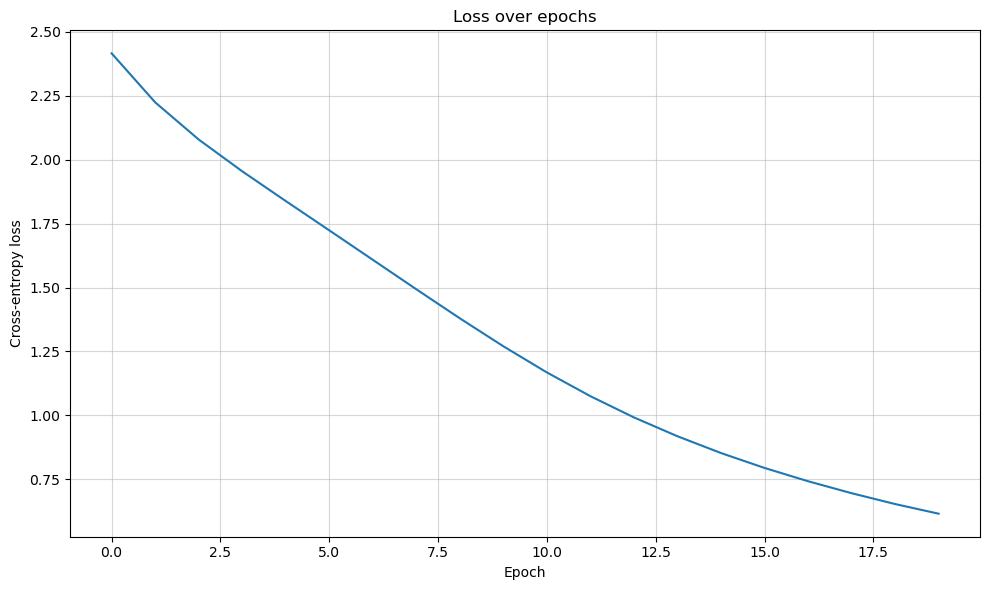

In [4]:
# Plot loss
nn.plot_loss()